In [1]:
import os 
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
labels=['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

In [3]:
DATASET_PATH = 'commands'
data_dir = pathlib.Path(DATASET_PATH)

In [4]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
print(commands)

['down' 'go' 'left' 'no' 'off' 'on' 'right' 'stop' 'up' 'yes']


In [5]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
     len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor: ', filenames[0])

Number of total examples: 23682
Number of examples per label: 2359
Example file tensor:  tf.Tensor(b'commands\\down\\190821dc_nohash_0.wav', shape=(), dtype=string)


In [6]:
train_files = filenames[:18945]
val_files = filenames[18495: 18495 + 2368]
test_files = filenames[-2368:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 18945
Validation set size 2368
Test set size 2368


In [7]:
test_file = tf.io.read_file(DATASET_PATH + '/go/00b01445_nohash_0.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([16000, 1])

In [8]:
def decode_audio(audio_binary):
    # Decode WAV-encoded audio files to `float32` tensors, normalized
    # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
    audio, _ = tf.audio.decode_wav(contents=audio_binary)
    # Since all the data is single channel (mono), drop the `channels`
    # axis from the array.
    return tf.squeeze(audio, axis=-1)

In [9]:
def get_label(file_path):
    parts = tf.strings.split(
        input=file_path,
        sep=os.path.sep)
    return parts[-2]

In [10]:
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

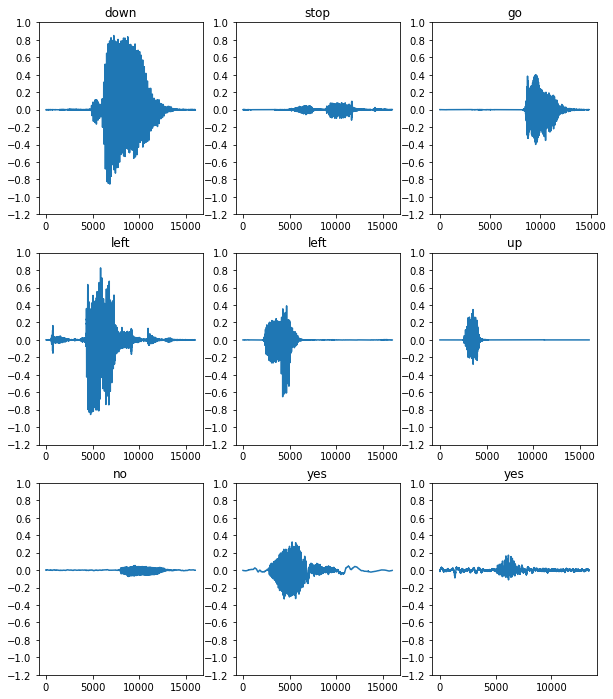

In [12]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)
    
plt.show()

In [13]:
def get_spectrogram(waveform):
    input_len = 16000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros(
        [16000] - tf.shape(waveform),
        dtype=tf.float32)
    waveform = tf.cast(waveform, dtype=tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(
        equal_length, frame_length=255,frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [14]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: down
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [15]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

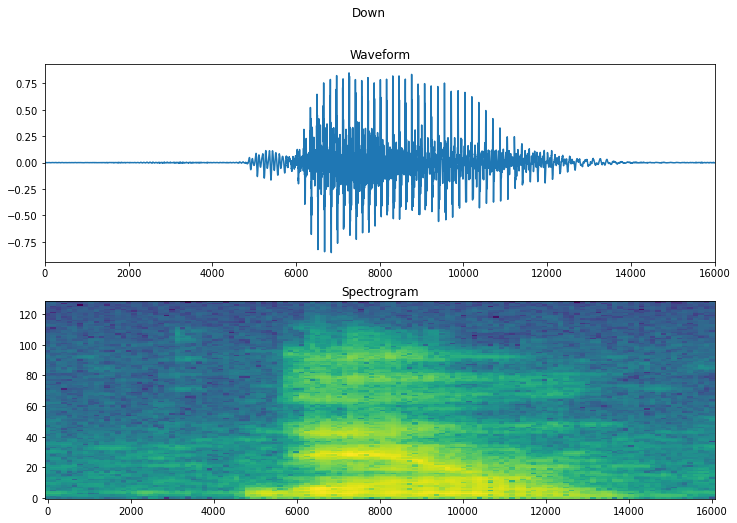

In [16]:
fig, axes = plt.subplots(2, figsize=(12,8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [17]:
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    label_id = tf.argmax(label == commands)
    return spectrogram, label_id

In [18]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

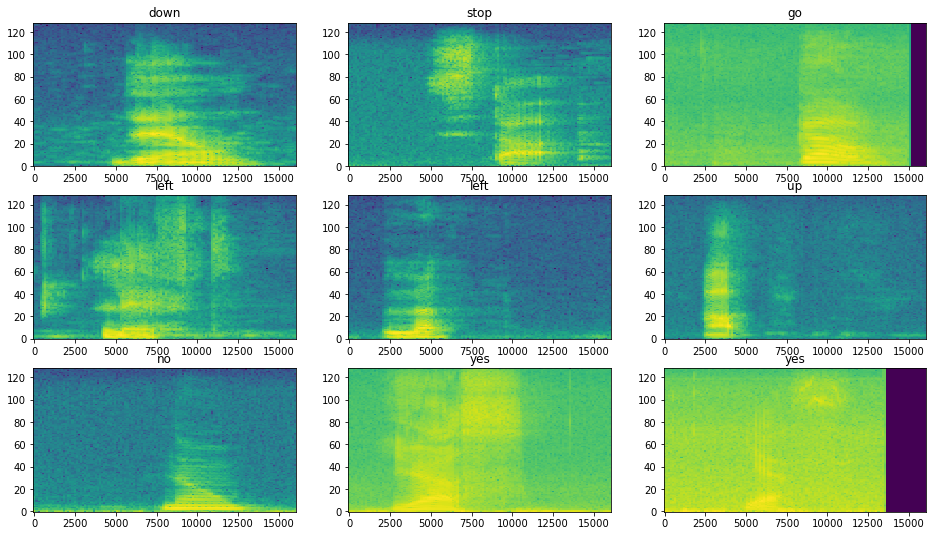

In [19]:
rows = 3 
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(spectrogram.numpy(), ax)
    ax.set_title(commands[label_id.numpy()])

plt.show()

In [55]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    waveform_ds = files_ds.map(
        map_func=get_waveform_and_label,
        num_parallel_calls=AUTOTUNE)
    spectrogram_ds = waveform_ds.map(
        map_func=get_spectrogram_and_label_id,
        num_parallel_calls=AUTOTUNE)
    return spectrogram_ds

In [56]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [57]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [58]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [60]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Input shape: ', input_shape)
num_labels = len(commands)
print(num_labels)

# Instantiate the 'tf.keras.layers.Normalization' layer
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with 'Normalization.adapt'.
# norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPool2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels)
])

model.summary()

Input shape:  (124, 129, 1)
10
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)       

In [61]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [64]:
%%time
EPOCHS = 30
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2))

Epoch 1/30
297/297 [==============================] - 71s 241ms/step - loss: 0.8742 - accuracy: 0.7077 - val_loss: 0.6162 - val_accuracy: 0.8180
Epoch 2/30
297/297 [==============================] - 38s 129ms/step - loss: 0.6639 - accuracy: 0.7743 - val_loss: 0.4977 - val_accuracy: 0.8480
Epoch 3/30
297/297 [==============================] - 38s 128ms/step - loss: 0.5354 - accuracy: 0.8170 - val_loss: 0.4459 - val_accuracy: 0.8552
Epoch 4/30
297/297 [==============================] - 41s 138ms/step - loss: 0.4624 - accuracy: 0.8410 - val_loss: 0.4011 - val_accuracy: 0.8796
Epoch 5/30
297/297 [==============================] - 42s 141ms/step - loss: 0.4080 - accuracy: 0.8616 - val_loss: 0.3705 - val_accuracy: 0.8801
Epoch 6/30
297/297 [==============================] - 42s 142ms/step - loss: 0.3732 - accuracy: 0.8738 - val_loss: 0.3430 - val_accuracy: 0.8885
Epoch 7/30
297/297 [==============================] - 41s 138ms/step - loss: 0.3352 - accuracy: 0.8849 - val_loss: 0.3484 - val_ac

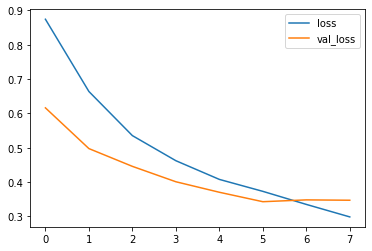

In [65]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [66]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [67]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

74/74 [==============================] - 1s 17ms/step
Test set accuracy: 88%


In [68]:
model.save('Model_2.h5')